## Connecting to google drive for access to data

Assuming that you have a folder in your root google drive directory that is called "Advanced analytics: assignment 2". In that folder there must be another folder called "data" that contains a folder with the images and a file "metadata.json".

- Google drive
  - Advanced analytics: assignment 2
    - data
      - images (folder)
      - metadata.json

You can use [the following link](https://drive.google.com/drive/folders/1-IF2CqxR-d-m6CYSy7SucqPCemMizpCl?usp=sharing) to copy the files if you want to :)

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir("drive/MyDrive/Advanced analytics: assignment 2")

Mounted at /content/drive


## Imports and reading data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from tqdm import tqdm
import pickle
from IPython.display import Image, display


import tensorflow as tf
import tensorflow.keras as K
from keras.preprocessing.image import load_img, img_to_array, array_to_img

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

metadata = pd.read_json("data/metadata.json", orient="index")

## Taking a look at some of the data

**We can start by taking a look at some random images**

We can take the min and max of the x and y variables. Next, those can be used as target for the model. Here you can see a demonstration of what that would look like. The red box is the original input and the points are the max and min.

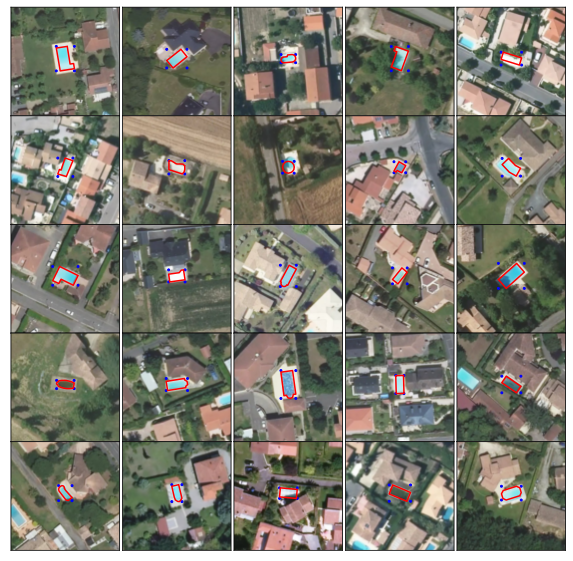

In [ ]:
def plot_image_bounding_box():
    plt.figure(figsize=(10, 10))
    for i in range(1, 26):
        plt.subplot(5, 5, i)
    
        # Sampling a random image and taking the coordinates of the bounding box
        location = metadata.sample(1).index.values[0]
        image = mpimg.imread("data/images/" + location)
        coordinates = metadata.loc[location]["bounds_x_y"]
        x = [i["x"] for i in coordinates]
        y = [i["y"] for i in coordinates]
        x_min = min(x)
        x_max = max(x)
        y_min = min(y)
        y_max = max(y)
        coordinates = np.column_stack((x, y))
        
        # Plotting the image and bounding box
        plt.imshow(image)
        plt.plot(coordinates[:, 0], coordinates[:, 1], c="r")
        plt.scatter(x_min, y_min, c="b", s=4)
        plt.scatter(x_min, y_max, c="b", s=4)
        plt.scatter(x_max, y_min, c="b", s=4)
        plt.scatter(x_max, y_max, c="b", s=4)
        plt.xticks([])
        plt.yticks([])

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


plot_image_bounding_box()

Some of these images are not that well labeled. Sometimes the bounding box is shifted or if there are multiple pools in one image, only one is labeled!



## Selecting and transforming the data

This cell will take some time. Sometimes it can look like it is stuck.



In [ ]:
def gen_coordinates(sample_size=1000):
    # Taking random coordinates
    coordinates = metadata.sample(sample_size).index.values
    available = np.array(os.listdir("data/images/"))

    # For some coordinates there is not an image available
    # Hence, discarding some of the coordinates:
    coordinates = np.array([i for i in coordinates if i in available])

    # Splitting into a train, validation and test set
    coord_train = coordinates[:int(len(coordinates)*0.8)]
    coord_val = coordinates[int(len(coordinates)*0.8):int(len(coordinates)*0.9)]
    coord_test = coordinates[int(len(coordinates)*0.9):]

    return coord_train, coord_val, coord_test


def gen_images(coordinates):
    """This functions takes coordinates, gets the images from the disk and
       loads them in the memory as an np array"""
    images = []
    for coordinate in tqdm(coordinates):
        try:
            # Loading image and normalising
            images.append(img_to_array(load_img("data/images/" + coordinate))
                          /256)
        except FileNotFoundError:
            coordinates = coordinates[coordinates != coordinate]
    images = np.array(images)

    return images


def gen_images_augmented(coordinates, output_dim=256):
    """Loads the images and targets into the memory as an array. Performs an
       operation on them so that there is a zoom (less dimensions) and the pool
       is not always in the middle."""
    images = []
    target = []
    for coordinate in tqdm(coordinates):
        try:
            # --- Loading image ---
            offset = int(np.random.uniform(-64, 64))

            # Loading image
            image_array = img_to_array(load_img("data/images/" + coordinate))

            # Shifting the image so the pool is not always in the middle
            # and zooming in
            image_array = image_array[
                # Split the image in half and add the offset
                int(output_dim/2)+offset:-int(output_dim/2)+offset,
                # Do the same for the y
                int(output_dim/2)+offset:-int(output_dim/2)+offset,
                # Take R, G and B
                :
            ]
            images.append(image_array)

            # --- Loading target ---
            # Get the coordinates of the target of this image
            bounding_box = metadata.loc[coordinate]["bounds_x_y"]
            
            x_array = [j["x"] - offset - output_dim/2 for j in bounding_box]
            y_array = [j["y"] - offset - output_dim/2 for j in bounding_box]

            min_x = min(x_array)
            max_x = max(x_array)
            min_y = min(y_array)
            max_y = max(y_array)

            target.append(np.array([min_x, max_x, min_y, max_y]))

        # If there is there is no image for the coordinate, we will delete this
        # coordinate from the list
        except FileNotFoundError:
            coordinates = coordinates[coordinates != coordinate]

    images = np.array(images)
    target = np.stack(target, axis=0)

    return images, target


def normalise(array, normalisation_factor=255):
    return array/normalisation_factor


coord_train, coord_val, coord_test = gen_coordinates(sample_size=3000)

x_train, y_train = gen_images_augmented(coord_train)
x_val, y_val = gen_images_augmented(coord_val)
x_test, y_test = gen_images_augmented(coord_test)

x_train = normalise(x_train)
x_val = normalise(x_val)
x_test = normalise(x_test)
y_train = normalise(y_train)
y_val = normalise(y_val)
y_test = normalise(y_test)

100%|██████████| 300/300 [00:06<00:00, 46.10it/s]


We can also take a quick look at one of the images that will be used for training

In [ ]:
def plot_image_target(image_array, target_array):
    # Selecting a random image
    image_idx = int(np.random.uniform(0, image_array.shape[0]))
    image = image_array[image_idx]
    target = target_array[image_idx]

    # Undoing normalisation
    image = image * 255
    target = target * 255

    # Plotting the image and target
    plt.imshow(image.astype(np.uint8))
    plt.scatter(target[0], target[2], c="r", s=8)
    plt.scatter(target[0], target[3], c="r", s=8)
    plt.scatter(target[1], target[2], c="r", s=8)
    plt.scatter(target[1], target[3], c="r", s=8)
    plt.xticks([])
    plt.yticks([])
    plt.show()


# plot_image_target(x_train, y_train)

## Building a model

In [ ]:
model = K.Sequential([
    K.layers.Conv2D(16, (4, 4), activation="relu", input_shape=(256, 256, 3)),
    K.layers.MaxPooling2D((4, 4)),
    K.layers.Conv2D(16, (3, 3), activation="relu"),
    K.layers.MaxPooling2D((3, 3)),
    K.layers.Flatten(),

    K.layers.Dense(512, activation="relu"),

    K.layers.Dropout(0.1),
    K.layers.Dense(256, activation="relu"),

    K.layers.Dropout(0.1),
    K.layers.Dense(128, activation="relu"),

    K.layers.Dropout(0.1),
    K.layers.Dense(64, activation="relu"),

    K.layers.Dense(4, activation="relu")
])

model.summary()
model.compile(optimizer=K.optimizers.SGD(learning_rate=0.01), loss="MSE")

history = model.fit(x=x_train, y=y_train, epochs=500,
                    validation_data=(x_val, y_val), verbose=2)

Visualizing the results on the test set.

The target is in red and the prediction is in blue

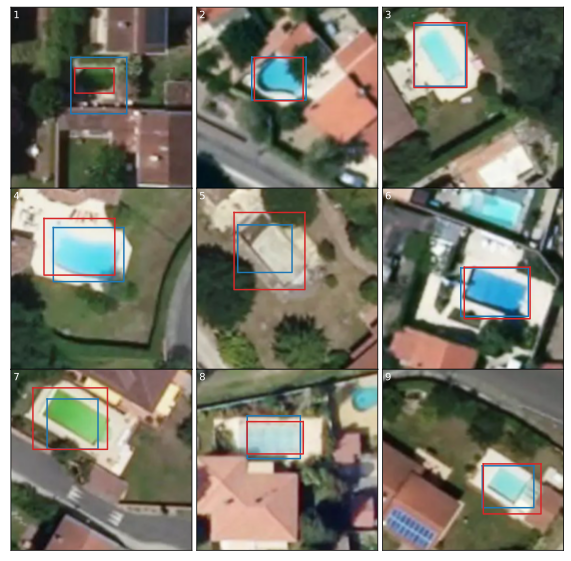

In [ ]:
def plot_test_pred(x_test, y_test, prediction):
    # Undoing normalization
    y_test = y_test * 256
    prediction = prediction * 256

    plt.figure(figsize=(10, 10))
    j = 1
    
    # Randomly selecting 9 predictions
    subselection = [int(i) for i in np.random.uniform(1, len(prediction), 9)]
    for i in subselection:
        plt.subplot(3, 3, j)
        # Sampling a random image and taking the coordinates of the bounding box
        image = array_to_img(x_test[i, :])

        # Plotting the image
        plt.imshow(image)
        
        # Plotting the prediction
        plt.plot(
            [prediction[i][0], prediction[i][0], prediction[i][1], prediction[i][1]],
            [prediction[i][2], prediction[i][3], prediction[i][3], prediction[i][2]],
            c="tab:blue"
        )
        plt.plot(
            [prediction[i][0], prediction[i][1]], [prediction[i][2], prediction[i][2]],
            c="tab:blue"
        )

        # Plotting the target
        plt.plot([y_test[i][0], y_test[i][0], y_test[i][1], y_test[i][1]],
                 [y_test[i][2], y_test[i][3], y_test[i][3], y_test[i][2]],
                 c="tab:red")
        plt.plot([y_test[i][0], y_test[i][1]], [y_test[i][2], y_test[i][2]],
                 c="tab:red")

        
        plt.text(3, 15, str(j), c="white")
        plt.xticks([])
        plt.yticks([])
        j += 1

    plt.subplots_adjust(wspace=0, hspace=0)

    plt.savefig("/content/drive/MyDrive/Advanced analytics: assignment 2/illustration.png",
                dpi=300)
    plt.show()


# prediction = model.predict(x_test)
# plot_test_pred(x_test, y_test, prediction)

In [ ]:
def plot_loss_total(history, save=False, show=False):
    plt.plot(history.history['loss'], c="tab:blue")
    plt.plot(history.history['val_loss'], c="tab:orange")
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    if save:
        plt.savefig("/content/drive/MyDrive/Advanced analytics: assignment 2/loss_total.png",
                    dpi=300)
    
    if show:
        plt.show() 


def plot_loss_zoom(history, save=False, show=False):
    plt.plot(history.history['loss'], c="tab:blue")
    plt.plot(history.history['val_loss'], c="tab:orange")
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.ylim(0.003, 0.01)

    if save:
        plt.savefig("/content/drive/MyDrive/Advanced analytics: assignment 2/loss_zoom.png",
                    dpi=300)
    
    if show:
        plt.show() 


plot_loss_total(history, save=True)
plot_loss_zoom(history, save=True)

100%|██████████| 1/1 [00:00<00:00, 43.95it/s]


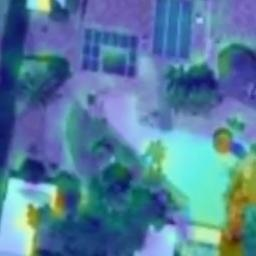

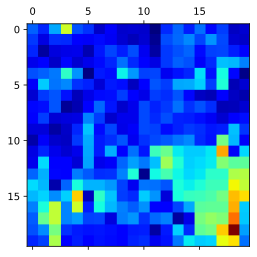

In [ ]:
# Following this guide:
# https://keras.io/examples/vision/grad_cam/

def gen_heatmap(img_array, model, last_conv_layer_name, pred_index=None,
                save=False, show=False):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output,
                         model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    if save:
        plt.matshow(heatmap, cmap="jet")
        path = "/content/drive/MyDrive/Advanced analytics: assignment 2/heatmaps/"
        plt.savefig(path + str(coordinate) + ".png", dpi=300)        

    if show:
        plt.matshow(heatmap, cmap="Blues")
        plt.show()

    return heatmap.numpy()


def vis_heatmap(heatmap, cam_path="cam.jpg", alpha=0.5):
    img = img_array[0]

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = K.preprocessing.image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    display(Image(cam_path))


# Randomly taking an image 
coordinate = metadata.sample(1).index.values
img_array, target = gen_images_augmented(coordinate)

# Generating the heatmap
heatmap = gen_heatmap(img_array, model, "max_pooling2d_1", save=True)
vis_heatmap(heatmap)


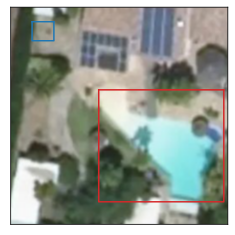

In [ ]:
plt.imshow(img_array[0] / 256)
prediction = model.predict(img_array)
plt.plot(
    [prediction[0][0], prediction[0][0], prediction[0][1], prediction[0][1]],
    [prediction[0][2], prediction[0][3], prediction[0][3], prediction[0][2]],
    c="tab:blue"
)
plt.plot(
    [prediction[0][0], prediction[0][1]], [prediction[0][2], prediction[0][2]],
    c="tab:blue"
)
plt.plot([target[0][0], target[0][0], target[0][1], target[0][1]],
         [target[0][2], target[0][3], target[0][3], target[0][2]],
         c="tab:red")
plt.plot([target[0][0], target[0][1]], [target[0][2], target[0][2]],
         c="tab:red")

plt.xticks([])
plt.yticks([])

plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig("/content/drive/MyDrive/Advanced analytics: assignment 2/prediction_wrong.png",
            dpi=300)
plt.show()